In [1]:
dataset_name = "artificial_cd_1"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 128

In [2]:
import adclasses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:939: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


# Preprocess dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

data["timestamp"] = pd.to_datetime(data["timestamp"], 
                                   format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, 
                                                                   '5min', data))

ad = adclasses.UnivariateAnomalyDetection(dataframe=data, 
                                          timestep="5min", 
                                          dateformat="%Y-%m-%d %H:%M:%S", 
                                          name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2014-04-01 16:40:00",
                      "2014-04-02 09:20:00",
                      "2014-04-03 02:00:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2014-04-01 00:00:00
End date:  2014-04-03 18:35:00
Missing time stamps: 
 DatetimeIndex([], dtype='datetime64[ns]', freq='5T')
Length:  800
Time step size:  5min
Start Date:  2014-04-01 00:00:00
End Date:  2014-04-03 18:35:00
Date Format:  %Y-%m-%d %H:%M:%S
True outlier indices:  [200, 400, 600]


# SARIMA: using autoarima

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=573.877, BIC=590.602, Fit time=0.055 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=567.913, BIC=573.488, Fit time=0.010 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=568.464, BIC=576.826, Fit time=0.022 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=568.682, BIC=577.044, Fit time=0.023 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=570.468, BIC=581.618, Fit time=0.027 seconds
Total fit time: 0.140 seconds
Final parameters:  (0, 0, 0, 0, 0, 0, 0)


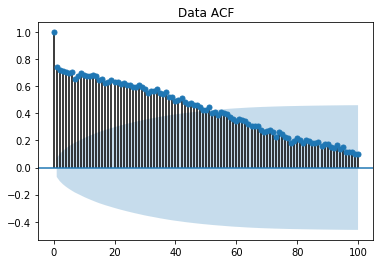

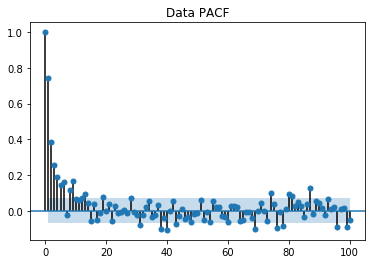

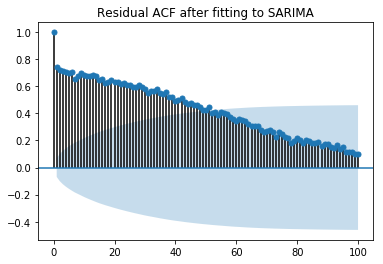

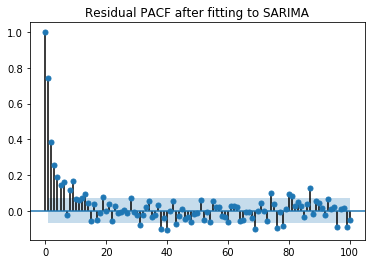

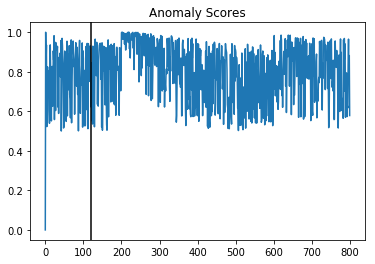

Time:  0.2998964786529541
RMSE:  11.370909688789306


['anomaly_scores/SARIMA_auto/artificial_cd_1']

In [4]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name
output_dict = ad.sarima(gaussian_window_size=gaussian_window_size,
                        autoarima=True, 
                        autoarima_season=False,
                        plot_acf=True, 
                        maxiter=3, 
                        plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# Facebook Prophet

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


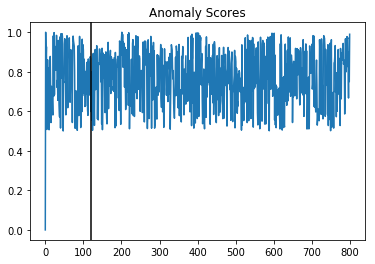

Time:  4.072055101394653
RMSE:  3.2411123526718195


['anomaly_scores/Prophet/artificial_cd_1']

In [5]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size,periods=0, interval_width=.999, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
print("RMSE: ", output_dict["RMSE"])
joblib.dump(output_dict, save_path)

# RNN

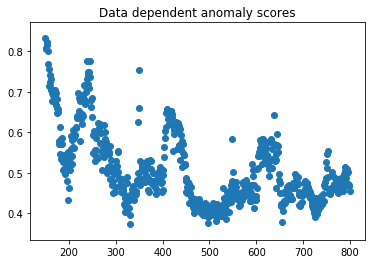

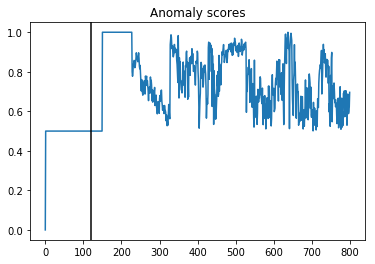

Time:  22.05459713935852


['anomaly_scores/RNN/artificial_cd_1']

In [5]:
save_path = "anomaly_scores/RNN/" + dataset_name
output_dict = ad.rnn(gaussian_window_size=gaussian_window_size,n_lag=100, n_seq=50, n_test=20, n_epochs=50,
                     n_batch=1, n_neurons=40, training_index=int(.15 * ad.get_length()), plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

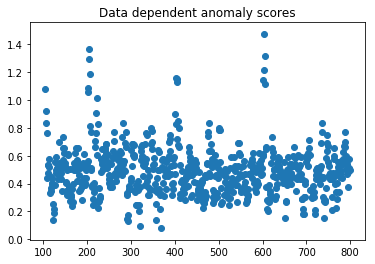

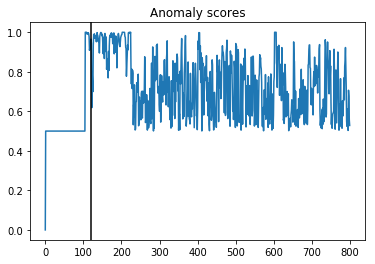

Time:  18.5259850025177


['anomaly_scores/RNN/artificial_cd_1']

In [6]:
save_path = "anomaly_scores/RNN/" + dataset_name
output_dict = ad.rnn(gaussian_window_size=gaussian_window_size,n_lag=100, n_seq=5, n_test=20, n_epochs=50,
                     n_batch=1, n_neurons=40, training_index=int(.15 * ad.get_length()), plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HTM

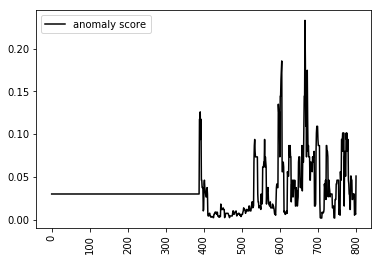

Time:  9.53


['anomaly_scores/HTM/artificial_cd_1']

In [7]:
htm_results_path = "htm_studio_results/" + "htm_results_" + dataset_name + "_value.csv"
htm_results = pd.read_csv(htm_results_path, header=0)

plt.plot(htm_results["raw_anomaly_score"], color="black", label="anomaly score")
plt.legend()
plt.xticks(rotation=90)
plt.show()

anomaly_scores = np.nan_to_num(htm_results["raw_anomaly_score"].values)

save_path = "anomaly_scores/HTM/" + dataset_name
print("Time: ", "9.53")
output_dict = {"Anomaly Scores": anomaly_scores, "Time": "9.53"}
joblib.dump(output_dict, save_path)

# Donut

Trainable Parameters              (27,950 in total)
---------------------------------------------------
donut/p_x_given_z/x_mean/bias    (20,)           20
donut/p_x_given_z/x_mean/kernel  (100, 20)    2,000
donut/p_x_given_z/x_std/bias     (20,)           20
donut/p_x_given_z/x_std/kernel   (100, 20)    2,000
donut/q_z_given_x/z_mean/bias    (5,)             5
donut/q_z_given_x/z_mean/kernel  (100, 5)       500
donut/q_z_given_x/z_std/bias     (5,)             5
donut/q_z_given_x/z_std/kernel   (100, 5)       500
sequential/_0/dense/bias         (100,)         100
sequential/_0/dense/kernel       (5, 100)       500
sequential/_1/dense/bias         (100,)         100
sequential/_1/dense/kernel       (100, 100)  10,000
sequential_1/_0/dense/bias       (100,)         100
sequential_1/_0/dense/kernel     (20, 100)    2,000
sequential_1/_1/dense/bias       (100,)         100
sequential_1/_1/dense/kernel     (100, 100)  10,000

[Epoch 10/256, Step 0, ETA 0.1558s] Learning rate decreased to 

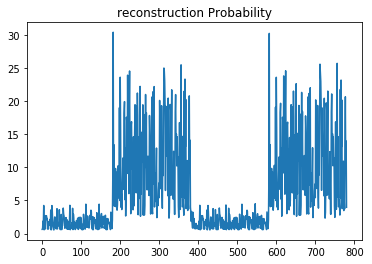

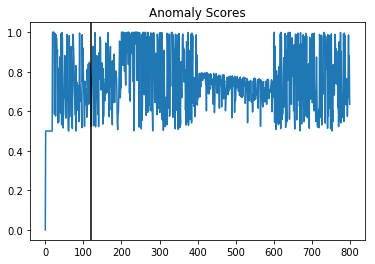

Time:  3.1399242877960205


['anomaly_scores/Donut/artificial_cd_1']

In [8]:
save_path = "anomaly_scores/Donut/" + dataset_name
output_dict = ad.donut(gaussian_window_size=gaussian_window_size,window_size=20, plot_reconstruction_prob=True, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# windowed gaussian

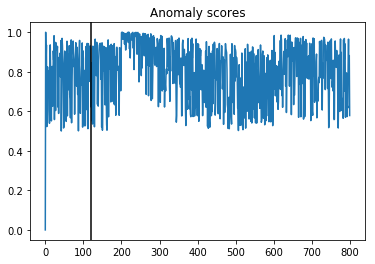

Time:  0.1331634521484375


['anomaly_scores/windowed_gaussian/artificial_cd_1']

In [10]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name
output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size,plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HOTSAX

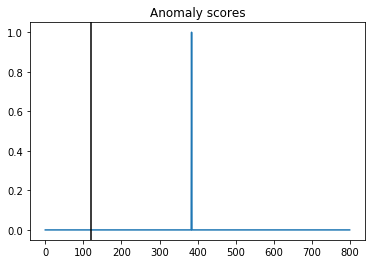

Time:  28.6350257396698


['anomaly_scores/hotsax/artificial_cd_1']

In [11]:
save_path = "anomaly_scores/hotsax/" + dataset_name
output_dict = ad.hotsax(win_size=50, num_discords=2,
               a_size=3, paa_size=3, z_threshold=0.01,
               plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

In [12]:
# no twitter bc no seasonality
# no stl bc no seasonality